# D209 - Classification Analysis

In [1]:
## Import libraries/packages
import numpy as np
from numpy.linalg import eig
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (18,10)
plt.rcParams['figure.max_open_warning'] = False
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.ensemble import GradientBoostingClassifier

## Data Preparation
---

In [2]:
## Import data
df = pd.read_csv('churn_clean.csv').reset_index(drop=True)

### Missing Values and Data Review
---

In [3]:
## Review shape and data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 50 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   CaseOrder             10000 non-null  int64  
 1   Customer_id           10000 non-null  object 
 2   Interaction           10000 non-null  object 
 3   UID                   10000 non-null  object 
 4   City                  10000 non-null  object 
 5   State                 10000 non-null  object 
 6   County                10000 non-null  object 
 7   Zip                   10000 non-null  int64  
 8   Lat                   10000 non-null  float64
 9   Lng                   10000 non-null  float64
 10  Population            10000 non-null  int64  
 11  Area                  10000 non-null  object 
 12  TimeZone              10000 non-null  object 
 13  Job                   10000 non-null  object 
 14  Children              10000 non-null  int64  
 15  Age                 

### Drop and Rename
---

In [4]:
## Drop granular data
df.drop([
    'CaseOrder', 
    'Customer_id', 
    'Interaction', 
    'UID', 
    'City', 
    'State',
    'County', 
    'Zip', 
    'Lat', 
    'Lng', 
    'TimeZone', 
    'Job'
], axis=1, inplace=True)

In [5]:
## Rename non-descript variables
df.rename({
    'Item1':'TimelyResponse',
    'Item2':'TimelyFixes',
    'Item3':'TimelyReplacements',
    'Item4':'Reliability',
    'Item5':'Options',
    'Item6':'RespectfulResponse',
    'Item7':'CourteousExchange',
    'Item8':'ActiveListening'
}, axis=1, inplace=True)

In [6]:
## Create a copy of the original data
df1 = df.copy()

### Duplicates and Outliers
---

In [7]:
## Check for duplicate values
print('Duplicate Values Found:', df.duplicated().sum())

Duplicate Values Found: 0


In [8]:
## Isolate string variables from numeric variables
object_df = pd.DataFrame()
for col in df.columns:
    if df[col].dtype == object:
        object_df[col] = df[col]
        df = df.drop(col, axis=1)

In [9]:
## Scale the data
scaler = StandardScaler()
df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

In [10]:
## Detect outliers
df[df.abs() > 3].dropna(how='all')

,Population,Children,Age,Income,Outage_sec_perweek,Email,Contacts,Yearly_equip_failure,Tenure,MonthlyCharge,Bandwidth_GB_Year,TimelyResponse,TimelyFixes,TimelyReplacements,Reliability,Options,RespectfulResponse,CourteousExchange,ActiveListening
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.091701,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.414525,NaN,NaN,NaN,NaN
20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.091701,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30,NaN,3.219376,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
46,NaN,NaN,NaN,3.273556,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9923,NaN,NaN,NaN,NaN,NaN,NaN,3.041027,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9967,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.091701,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9972,NaN,NaN,NaN,NaN,NaN,NaN,3.041027,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9987,5.387511,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
## Remove observations with absolute zscore over 3
df = df[df.abs() < 3].dropna()

In [12]:
## Evaluate data loss
lost = ((len(object_df) - len(df)) / len(object_df)) * 100
print('Data Lost: {}%\nData Kept: {}%'.format(lost, 100-lost))

Data Lost: 9.15%
Data Kept: 90.85%


In [13]:
## Drop same outlier observations from object data frame
object_df = object_df.loc[df.index]

### Encode Categoricals
---

In [14]:
## Define dictionary for contract variable
contract = {
    'Month-to-month': 0,
    'One year': 1,
    'Two Year': 2
}

## Encode the contract variable and drop it from object df
df['Contract'] = object_df['Contract'].map(contract)
object_df.drop('Contract', axis=1, inplace=True)

In [15]:
## Instantiate the label encoder
le = LabelEncoder()
## Loop through each variable to encode it
for col in object_df.columns:
    if 'Yes' in object_df[col].values:
        df[col] = le.fit_transform(object_df[col])
        object_df.drop(col, axis=1, inplace=True)

In [16]:
## Get dummy variables
object_df = pd.get_dummies(object_df)

In [17]:
## Combine data frames
df[object_df.columns] = object_df

### Store Clean Data
---

In [18]:
## Save clean data set to csv file
df.to_csv('knn_clean.csv')

### Split Train and Test
---

In [19]:
## Isolate the target variable from the data
X, y = df.drop('Churn', axis=1), df['Churn']

In [20]:
## Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7)

In [21]:
## Combine target and explanatory variables
X_train['Churn'] = y_train
X_test['Churn'] = y_test

### Store Train and Test
---

In [22]:
## Save training and testing data sets to csv files
X_train.to_csv('knn_train.csv')
X_test.to_csv('knn_test.csv')

In [23]:
## Drop target variable from train and test sets
X_train.drop('Churn', axis=1, inplace=True)
X_test.drop('Churn', axis=1, inplace=True)

### Cross Validation for k
---

In [24]:
## Create a dictionary to store model metrics
k_scores = {}

In [25]:
## Loop through k values 10 times
for k in range(1,11):
    ## Define the knn classifier model
    knn = KNeighborsClassifier(n_neighbors=k)
    ## Evaluate the model using cross-validation
    results = cross_val_score(knn, X, y, cv=10, scoring='accuracy')
    ## Store the average cv score and k
    k_scores[k] = results.mean()

In [26]:
## Select the highest scoring model
k = max(k_scores, key=k_scores.get)

### Fit, Test, and Score the Model
---

In [27]:
## Fit the model using the training set
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=9)

In [28]:
## Score the final model
score = knn.score(X_test, y_test)

In [29]:
print(f'Accuracy: {round(score*100, 2)}%')

Accuracy: 84.45%


In [30]:
y_pred = knn.predict(X_test)

In [31]:
## Define function to plot confusion matrix
def plot_cm(y_test, y_pred, mod_name):
    ## Get confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    ## Plot confusion matrix
    labels = ['Positive', 'Negative']
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title('Confusion Matrix: {}'.format(mod_name))
    plt.show()

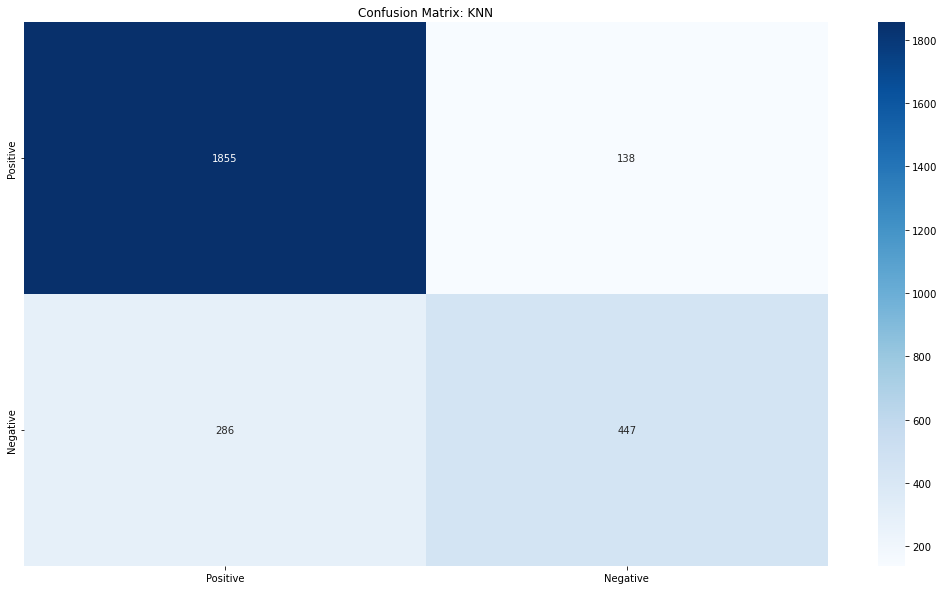

In [32]:
## Plot the confusion matrix for the knn model
plot_cm(y_test, y_pred, 'KNN')

In [33]:
## Get model probabilities
y_pred_prob = knn.predict_proba(X_test)[:,1]

In [34]:
## Calculate false and true positive rates
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

In [35]:
## Calculate the AUC
auc_score = auc(fpr, tpr)
print(f'AUC: {auc_score}')

AUC: 0.8981965528736664


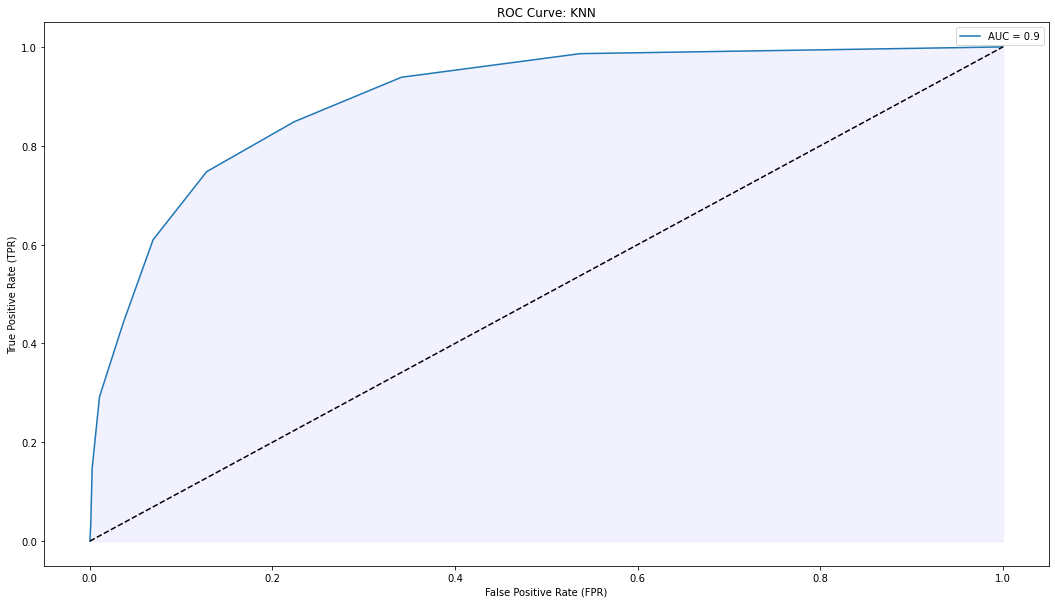

In [36]:
## Plot the ROC curve
plt.plot(fpr, tpr, label=f'AUC = {round(auc_score, 2)}')
## Plot the diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--')
## Fill the area under the curve
plt.fill_between(fpr, tpr, color='blue', alpha=0.05)
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve: KNN')
plt.legend()
plt.show()

### Understand Feature Importance
---

In [37]:
## Instantiate the gradient boosting model
gini = GradientBoostingClassifier(n_estimators=1000, random_state=10, n_iter_no_change=10)

In [38]:
## Fit the model
gini.fit(X_train, y_train)

GradientBoostingClassifier(n_estimators=1000, n_iter_no_change=10,
                           random_state=10)

In [39]:
## Print the stopping n_estimators value
print(f'Best n_estimators Value: {gini.n_estimators_}')

Best n_estimators Value: 149


In [40]:
## Print the model's accuracy score
print(f'Accuracy: {round(gini.score(X, y)*100, 2)}%')

Accuracy: 91.49%


In [41]:
## Store the Gini importance values
importance = pd.DataFrame(gini.feature_importances_, index=gini.feature_names_in_, columns=['gini'])
importance.sort_values('gini', ascending=False, inplace=True)

In [42]:
importance.head(8)

,gini
Tenure,0.419840
MonthlyCharge,0.215035
Contract,0.155392
StreamingMovies,0.074470
StreamingTV,0.041383
Bandwidth_GB_Year,0.020112
InternetService_DSL,0.017511
InternetService_Fiber Optic,0.014671


### Predict High Churn Risk
---

In [43]:
## Create data frame from customers that have not churned
not_churned = df[df.Churn == 0]

In [44]:
## Split target and explanatory variables
X_true, y_true = not_churned.drop('Churn', axis=1), not_churned['Churn']

In [45]:
## Predict what currentcustomers are at highest risk of churn
y_pred = knn.predict(X_true)

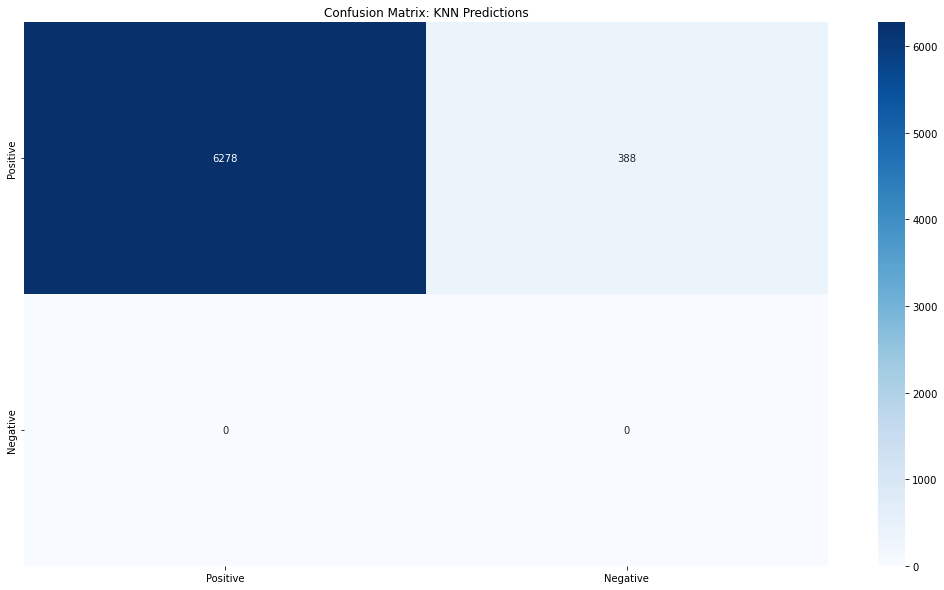

In [46]:
plot_cm(y_true, y_pred, 'KNN Predictions')

In [47]:
## Get model probabilities
y_pred_prob = knn.predict_proba(X_true)[:,1]

In [48]:
## Calculate the amount of positive and negative predictions
pos = np.count_nonzero(y_pred!=0)
neg = np.count_nonzero(y_pred==0)
pos, neg

(388, 6278)

In [49]:
## Calculate the false and true, positive and negative rates
fpr = fpr.mean()
tpr = tpr.mean()
fnr = 1 - tpr.mean()
tnr = 1 - fnr

In [50]:
## Calculate the amount of false positives and negatives
fp = int(fpr * neg)
fn = int((1 - tpr) * pos)

In [51]:
## Compare false negative and positive rates
fnr, fpr

(0.45032866178841624, 0.21361127582903802)

In [52]:
## Combine the predicted values with explanatory features
X_true['Churn'] = y_pred

### Review High Churn Risk Customers
---

In [53]:
## Recall the customers that have been predicted to churn
churn = df1.loc[X_true[X_true.Churn == 1].index].drop('Churn', axis=1).reset_index(drop=True)

In [54]:
churn[['Tenure', 'MonthlyCharge', 'Bandwidth_GB_Year']].describe()

,Tenure,MonthlyCharge,Bandwidth_GB_Year
count,388.000000,388.000000,388.000000
mean,10.601954,178.602950,1396.376984
std,7.639235,36.600657,711.959508
min,1.042141,94.972827,223.476583
25%,5.447317,149.982819,935.455451
50%,9.357367,179.947583,1291.718181
75%,14.477495,204.963378,1762.640120
max,67.736390,287.642700,6667.024092


In [55]:
for feature in churn[['Contract', 'StreamingTV', 'StreamingMovies', 'InternetService']]:
    print(churn[feature].value_counts())

Month-to-month    213
One year          123
Two Year           52
Name: Contract, dtype: int64
No     201
Yes    187
Name: StreamingTV, dtype: int64
Yes    203
No     185
Name: StreamingMovies, dtype: int64
Fiber Optic    220
DSL             95
None            73
Name: InternetService, dtype: int64
